In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dfL = pd.read_csv('takehome_users.csv')
dfL.sample(5)
dfL['creation_time'] = pd.to_datetime(dfL['creation_time'])
dfL['last_session_creation_time'] = pd.to_datetime(dfL['last_session_creation_time'], unit='s')

len(dfL)
dfL.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [3]:
dfE = pd.read_csv('takehome_user_engagement.csv', index_col='time_stamp')
dfE.index = pd.to_datetime(dfE.index)
dfE.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [4]:
print('User logins length: {} and engagement length: {}'.format(len(dfL),len(dfE)))

User logins length: 12000 and engagement length: 207917


In [5]:
dfL.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
dtype: object

In [6]:
betweenLastLogin = []

for i in range(len(dfL)):
    
    betweenTime = dfL.iloc[i]['last_session_creation_time'] - dfL.iloc[i]['creation_time']
    days = betweenTime.days
    betweenLastLogin.append(days)
    

    
dfL['betweenLastLogin'] = betweenLastLogin
dfL.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,betweenLastLogin
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,136.0


In [7]:
dfL['source'] = 0
dfL['source'] = pd.get_dummies(dfL['creation_source'], drop_first=True)
dfL.drop('creation_source', axis=1, inplace=True)

dfL.drop(columns=['name', 'email', 'last_session_creation_time', 'creation_time', 'invited_by_user_id','object_id'], axis=1, inplace=True)

dfL.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,betweenLastLogin,source
0,1,0,11,0.0,0
1,0,0,1,136.0,1
2,0,0,94,0.0,1
3,0,0,1,1.0,0
4,0,0,193,5.0,0


In [8]:
labels = []
for i in range(1,12001):
    userLogins = dfE.loc[dfE.user_id == i]
    resampled = userLogins.rolling('7d').count()
    if resampled.loc[resampled.visited >= 3].shape[0] > 0:
        adopted = 1
    else:
        adopted = 0
        
    labels.append(adopted)
    
    
dfL['adopted'] = labels
len(dfL.loc[dfL['adopted'] ==1])

1602

In [9]:
dfL.head(3)

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,betweenLastLogin,source,adopted
0,1,0,11,0.0,0,0
1,0,0,1,136.0,1,1
2,0,0,94,0.0,1,0


In [10]:
dfL.columns

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'betweenLastLogin', 'source', 'adopted'],
      dtype='object')

In [11]:
dfL.fillna({'betweenLastLogin':0}, inplace=True)
dfL.isnull().sum()

opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
betweenLastLogin              0
source                        0
adopted                       0
dtype: int64

In [12]:
dfL['betweenLastLogin']

0          0.0
1        136.0
2          0.0
3          1.0
4          5.0
         ...  
11995      0.0
11996      5.0
11997      0.0
11998      2.0
11999      0.0
Name: betweenLastLogin, Length: 12000, dtype: float64

In [15]:
from sklearn.preprocessing import StandardScaler
features = [ 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'org_id', 'betweenLastLogin', 'source',
       'adopted']

target = dfL.adopted

# Separating out the features
x = dfL.loc[:, features].values
# Separating out the target
y = dfL.loc[:,['adopted']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [23]:
dfL.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,betweenLastLogin,source,adopted
0,1,0,11,0.0,0,0
1,0,0,1,136.0,1,1
2,0,0,94,0.0,1,0
3,0,0,1,1.0,0,0
4,0,0,193,5.0,0,0


In [22]:
dfL.adopted.mean()

0.1335

In [25]:
from sklearn.model_selection import train_test_split

target = 'adopted'
X = dfL.drop(target, axis=1)
y = dfL[[target]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

In [28]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from scipy.stats import ttest_ind
from sklearn.model_selection import GridSearchCV

# GridSearchCV

n_estimator_space = [50, 100, 200]
max_features_space = [2, 'sqrt', 5]
class_weight_space = ['balanced', 'balanced_subsample', None]
criterion_space = ['gini', 'entropy']

param_grid = {'n_estimators': n_estimator_space, 
              'max_features': max_features_space, 
              'class_weight': class_weight_space, 
              'criterion': criterion_space}

rf_tune = RandomForestClassifier(random_state=13)
rf_cv = GridSearchCV(rf_tune, param_grid, cv=3, scoring='roc_auc')
rf_cv.fit(X_train, y_train.values.ravel())
print(rf_cv.best_params_)
print(rf_cv.best_score_)



{'class_weight': None, 'criterion': 'entropy', 'max_features': 2, 'n_estimators': 200}
0.9906965478820539


In [31]:
# Run random forest 

rf = RandomForestClassifier(n_estimators = 200,
                           max_features = 2,
                           criterion = "entropy",
                           class_weight= None,
                           random_state=13)
rfModel = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)

print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

print("Classification Report")
print(metrics.classification_report(y_test, y_pred))

Confusion Matrix:
[[2042   38]
 [  42  278]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2080
           1       0.88      0.87      0.87       320

    accuracy                           0.97      2400
   macro avg       0.93      0.93      0.93      2400
weighted avg       0.97      0.97      0.97      2400



In [32]:
#RF Feature Importances
feature_importances = pd.DataFrame()
feature_importances["feature"] = X_train.columns
feature_importances["importance"] = rf_model.feature_importances_
feature_importances.sort_values(by='importance', ascending=False).head(10)

,feature,importance
3,betweenLastLogin,0.902480
2,org_id,0.087995
4,source,0.003798
0,opted_in_to_mailing_list,0.003122
1,enabled_for_marketing_drip,0.002605


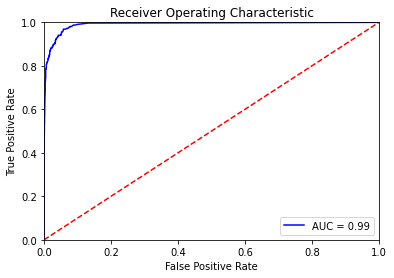

In [33]:
# ROC Curve


probs = y_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, probs, pos_label=1.)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

principalComponents

array([[-0.57158107,  0.93065482],
       [ 2.12421345, -0.80171139],
       [-0.61740306, -0.65909906],
       ...,
       [-0.41889355,  2.9176771 ],
       [-0.6406489 , -0.7021138 ],
       [-0.5656504 ,  1.27938201]])

In [18]:
finalDf = pd.concat([principalDf, dfL[['adopted']]], axis = 1)
finalDf.drop('adopted', axis=1, inplace=True)


In [19]:
finalDf.head()

,principal component 1,principal component 2
0,-0.571581,0.930655
1,2.124213,-0.801711
2,-0.617403,-0.659099
3,-0.650473,-0.702243
4,-0.464367,-0.688402


In [34]:
group = dfE.groupby('user_id')


for i in group:
    print(i)


(1,                      user_id  visited
time_stamp                           
2014-04-22 03:53:30        1        1)
(2,                      user_id  visited
time_stamp                           
2013-11-15 03:45:04        2        1
2013-11-29 03:45:04        2        1
2013-12-09 03:45:04        2        1
2013-12-25 03:45:04        2        1
2013-12-31 03:45:04        2        1
2014-01-08 03:45:04        2        1
2014-02-03 03:45:04        2        1
2014-02-08 03:45:04        2        1
2014-02-09 03:45:04        2        1
2014-02-13 03:45:04        2        1
2014-02-16 03:45:04        2        1
2014-03-09 03:45:04        2        1
2014-03-13 03:45:04        2        1
2014-03-31 03:45:04        2        1)
(3,                      user_id  visited
time_stamp                           
2013-03-19 23:14:52        3        1)
(4,                      user_id  visited
time_stamp                           
2013-05-22 08:09:28        4        1)
(5,                      user_

2012-09-30 23:27:02       99        1)
(100,                      user_id  visited
time_stamp                           
2013-06-17 08:41:36      100        1)
(101,                      user_id  visited
time_stamp                           
2013-08-16 22:38:05      101        1)
(103,                      user_id  visited
time_stamp                           
2012-12-02 10:44:08      103        1)
(105,                      user_id  visited
time_stamp                           
2012-11-25 14:35:19      105        1)
(106,                      user_id  visited
time_stamp                           
2012-09-23 06:34:37      106        1)
(107,                      user_id  visited
time_stamp                           
2013-09-23 05:39:25      107        1)
(109,                      user_id  visited
time_stamp                           
2012-08-31 05:18:22      109        1)
(110,                      user_id  visited
time_stamp                           
2013-11-03 14:02:47      110    

2013-07-16 01:46:58      227        1)
(228,                      user_id  visited
time_stamp                           
2013-07-16 00:34:23      228        1)
(230,                      user_id  visited
time_stamp                           
2013-03-22 22:47:50      230        1
2013-04-29 22:47:50      230        1
2013-05-19 22:47:50      230        1
2013-05-25 22:47:50      230        1
2013-05-26 22:47:50      230        1
...                      ...      ...
2014-05-31 22:47:50      230        1
2014-06-01 22:47:50      230        1
2014-06-02 22:47:50      230        1
2014-06-03 22:47:50      230        1
2014-06-04 22:47:50      230        1

[305 rows x 2 columns])
(232,                      user_id  visited
time_stamp                           
2013-10-18 17:43:35      232        1)
(234,                      user_id  visited
time_stamp                           
2014-05-30 15:44:36      234        1)
(235,                      user_id  visited
time_stamp                   

2013-07-26 13:14:23      379        1)
(381,                      user_id  visited
time_stamp                           
2014-04-20 12:13:26      381        1)
(382,                      user_id  visited
time_stamp                           
2013-05-07 23:50:28      382        1
2013-05-12 23:50:28      382        1
2013-05-25 23:50:28      382        1)
(383,                      user_id  visited
time_stamp                           
2014-01-21 07:11:50      383        1
2014-01-24 07:11:50      383        1
2014-02-05 07:11:50      383        1
2014-03-03 07:11:50      383        1
2014-04-02 07:11:50      383        1
2014-04-10 07:11:50      383        1
2014-04-13 07:11:50      383        1
2014-04-14 07:11:50      383        1
2014-04-21 07:11:50      383        1
2014-04-22 07:11:50      383        1
2014-04-24 07:11:50      383        1
2014-04-27 07:11:50      383        1
2014-05-03 07:11:50      383        1
2014-05-12 07:11:50      383        1
2014-05-15 07:11:50      383 

2014-03-19 04:32:11      534        1)
(535,                      user_id  visited
time_stamp                           
2013-04-29 17:37:34      535        1
2013-05-04 17:37:34      535        1
2013-05-16 17:37:34      535        1
2013-05-30 17:37:34      535        1
2013-06-06 17:37:34      535        1
...                      ...      ...
2014-05-21 17:37:34      535        1
2014-05-22 17:37:34      535        1
2014-05-23 17:37:34      535        1
2014-05-24 17:37:34      535        1
2014-05-25 17:37:34      535        1

[250 rows x 2 columns])
(536,                      user_id  visited
time_stamp                           
2013-02-19 11:14:11      536        1)
(537,                      user_id  visited
time_stamp                           
2013-07-02 11:22:27      537        1)
(538,                      user_id  visited
time_stamp                           
2013-09-09 22:15:14      538        1)
(539,                      user_id  visited
time_stamp                   

2014-02-24 14:24:43      674        1)
(675,                      user_id  visited
time_stamp                           
2013-03-24 10:23:08      675        1
2013-04-06 10:23:08      675        1)
(676,                      user_id  visited
time_stamp                           
2014-02-18 11:18:15      676        1)
(677,                      user_id  visited
time_stamp                           
2013-10-01 03:27:14      677        1)
(678,                      user_id  visited
time_stamp                           
2013-01-20 19:52:44      678        1)
(679,                      user_id  visited
time_stamp                           
2012-10-29 17:02:48      679        1
2012-11-21 17:02:48      679        1
2012-11-30 17:02:48      679        1
2012-12-01 17:02:48      679        1
2012-12-03 17:02:48      679        1
...                      ...      ...
2014-05-31 17:02:48      679        1
2014-06-01 17:02:48      679        1
2014-06-02 17:02:48      679        1
2014-06-03 17:0

2013-03-20 09:07:57      802        1)
(804,                      user_id  visited
time_stamp                           
2013-03-26 00:00:13      804        1
2013-05-13 00:00:13      804        1
2013-05-23 00:00:13      804        1
2013-05-28 00:00:13      804        1
2013-06-03 00:00:13      804        1
...                      ...      ...
2014-05-12 00:00:13      804        1
2014-05-16 00:00:13      804        1
2014-05-17 00:00:13      804        1
2014-05-23 00:00:13      804        1
2014-05-27 00:00:13      804        1

[109 rows x 2 columns])
(805,                      user_id  visited
time_stamp                           
2013-10-01 14:49:37      805        1)
(808,                      user_id  visited
time_stamp                           
2014-05-13 10:05:20      808        1)
(809,                      user_id  visited
time_stamp                           
2014-03-07 01:35:45      809        1)
(810,                      user_id  visited
time_stamp                   

2013-07-22 01:44:26     1104        1)
(1105,                      user_id  visited
time_stamp                           
2012-09-22 20:21:09     1105        1)
(1106,                      user_id  visited
time_stamp                           
2014-04-18 04:29:08     1106        1
2014-04-27 04:29:08     1106        1
2014-05-12 04:29:08     1106        1
2014-05-13 04:29:08     1106        1
2014-05-16 04:29:08     1106        1
2014-05-19 04:29:08     1106        1
2014-05-21 04:29:08     1106        1
2014-05-23 04:29:08     1106        1
2014-05-28 04:29:08     1106        1)
(1107,                      user_id  visited
time_stamp                           
2013-07-21 09:49:48     1107        1
2013-07-26 09:49:48     1107        1
2013-07-27 09:49:48     1107        1
2013-08-18 09:49:48     1107        1
2013-08-21 09:49:48     1107        1
2013-08-23 09:49:48     1107        1
2013-09-01 09:49:48     1107        1
2013-09-03 09:49:48     1107        1
2013-09-11 09:49:48     11

2014-05-16 10:23:33     1568        1)
(1569,                      user_id  visited
time_stamp                           
2014-04-15 11:31:48     1569        1)
(1570,                      user_id  visited
time_stamp                           
2014-01-17 17:24:49     1570        1)
(1571,                      user_id  visited
time_stamp                           
2013-08-02 11:56:17     1571        1
2013-08-19 11:56:17     1571        1)
(1572,                      user_id  visited
time_stamp                           
2014-03-29 22:59:18     1572        1)
(1573,                      user_id  visited
time_stamp                           
2014-01-30 07:21:06     1573        1)
(1574,                      user_id  visited
time_stamp                           
2013-04-14 03:24:19     1574        1)
(1576,                      user_id  visited
time_stamp                           
2013-03-16 15:42:17     1576        1
2013-03-19 15:42:17     1576        1
2013-04-12 15:42:17     1576    

2013-11-06 09:39:41     1878        1)
(1879,                      user_id  visited
time_stamp                           
2012-10-02 04:13:24     1879        1
2012-10-26 04:13:24     1879        1
2012-11-10 04:13:24     1879        1
2012-11-20 04:13:24     1879        1
2012-12-28 04:13:24     1879        1
...                      ...      ...
2014-05-31 04:13:24     1879        1
2014-06-01 04:13:24     1879        1
2014-06-02 04:13:24     1879        1
2014-06-03 04:13:24     1879        1
2014-06-04 04:13:24     1879        1

[266 rows x 2 columns])
(1880,                      user_id  visited
time_stamp                           
2013-11-04 13:02:25     1880        1)
(1881,                      user_id  visited
time_stamp                           
2014-04-06 03:38:49     1881        1)
(1883,                      user_id  visited
time_stamp                           
2013-11-30 03:22:06     1883        1)
(1885,                      user_id  visited
time_stamp              

[97 rows x 2 columns])
(2004,                      user_id  visited
time_stamp                           
2013-10-30 16:27:19     2004        1)
(2006,                      user_id  visited
time_stamp                           
2014-02-28 17:24:15     2006        1)
(2007,                      user_id  visited
time_stamp                           
2012-08-31 20:22:29     2007        1)
(2009,                      user_id  visited
time_stamp                           
2014-04-15 06:22:49     2009        1
2014-04-20 06:22:49     2009        1
2014-04-21 06:22:49     2009        1
2014-04-29 06:22:49     2009        1
2014-04-30 06:22:49     2009        1
2014-05-10 06:22:49     2009        1)
(2011,                      user_id  visited
time_stamp                           
2013-01-18 17:54:53     2011        1
2013-02-10 17:54:53     2011        1
2013-02-16 17:54:53     2011        1
2013-02-26 17:54:53     2011        1
2013-03-03 17:54:53     2011        1
...                      .

2012-07-15 00:42:50     2128        1)
(2129,                      user_id  visited
time_stamp                           
2014-01-30 20:49:26     2129        1
2014-03-05 20:49:26     2129        1
2014-03-16 20:49:26     2129        1
2014-03-29 20:49:26     2129        1
2014-04-02 20:49:26     2129        1
2014-04-14 20:49:26     2129        1
2014-04-23 20:49:26     2129        1
2014-04-29 20:49:26     2129        1
2014-04-30 20:49:26     2129        1
2014-05-03 20:49:26     2129        1
2014-05-06 20:49:26     2129        1
2014-05-12 20:49:26     2129        1
2014-05-21 20:49:26     2129        1)
(2131,                      user_id  visited
time_stamp                           
2013-03-02 12:09:08     2131        1
2013-04-10 12:09:08     2131        1
2013-05-03 12:09:08     2131        1)
(2132,                      user_id  visited
time_stamp                           
2012-06-10 01:50:14     2132        1)
(2134,                      user_id  visited
time_stamp        

2012-08-05 01:04:32     2242        1)
(2243,                      user_id  visited
time_stamp                           
2014-04-26 23:37:47     2243        1)
(2246,                      user_id  visited
time_stamp                           
2012-11-15 22:44:17     2246        1
2012-11-26 22:44:17     2246        1
2012-11-30 22:44:17     2246        1
2012-12-03 22:44:17     2246        1
2012-12-07 22:44:17     2246        1
...                      ...      ...
2014-05-23 22:44:17     2246        1
2014-05-24 22:44:17     2246        1
2014-05-26 22:44:17     2246        1
2014-05-27 22:44:17     2246        1
2014-05-28 22:44:17     2246        1

[178 rows x 2 columns])
(2247,                      user_id  visited
time_stamp                           
2013-08-10 12:07:07     2247        1)
(2248,                      user_id  visited
time_stamp                           
2012-08-21 23:24:44     2248        1)
(2251,                      user_id  visited
time_stamp              

[220 rows x 2 columns])
(2327,                      user_id  visited
time_stamp                           
2014-02-04 02:03:23     2327        1)
(2328,                      user_id  visited
time_stamp                           
2013-04-30 13:39:21     2328        1)
(2331,                      user_id  visited
time_stamp                           
2013-05-15 14:45:04     2331        1)
(2332,                      user_id  visited
time_stamp                           
2013-06-26 10:45:20     2332        1
2013-07-07 10:45:20     2332        1
2013-08-08 10:45:20     2332        1)
(2333,                      user_id  visited
time_stamp                           
2012-09-24 17:48:45     2333        1
2012-09-29 17:48:45     2333        1
2012-10-23 17:48:45     2333        1
2012-10-27 17:48:45     2333        1
2012-10-28 17:48:45     2333        1
...                      ...      ...
2014-05-28 17:48:45     2333        1
2014-05-29 17:48:45     2333        1
2014-05-30 17:48:45     2

2013-12-04 16:23:02     2430        1)
(2431,                      user_id  visited
time_stamp                           
2012-07-16 00:15:41     2431        1)
(2432,                      user_id  visited
time_stamp                           
2012-10-13 00:21:00     2432        1)
(2433,                      user_id  visited
time_stamp                           
2014-05-25 23:33:04     2433        1)
(2434,                      user_id  visited
time_stamp                           
2013-10-05 21:01:56     2434        1
2013-10-24 21:01:56     2434        1)
(2435,                      user_id  visited
time_stamp                           
2013-05-07 01:12:28     2435        1
2013-06-21 01:12:28     2435        1
2013-06-29 01:12:28     2435        1
2013-07-10 01:12:28     2435        1
2013-07-13 01:12:28     2435        1
2013-07-20 01:12:28     2435        1
2013-07-21 01:12:28     2435        1
2013-07-27 01:12:28     2435        1
2013-07-29 01:12:28     2435        1
2013-08-12

2012-12-23 01:44:20     2605        1)
(2607,                      user_id  visited
time_stamp                           
2014-05-27 06:50:44     2607        1)
(2608,                      user_id  visited
time_stamp                           
2012-08-23 13:57:18     2608        1)
(2609,                      user_id  visited
time_stamp                           
2013-12-04 02:17:12     2609        1)
(2610,                      user_id  visited
time_stamp                           
2012-08-18 23:29:20     2610        1
2012-08-19 23:29:20     2610        1
2012-08-20 23:29:20     2610        1
2012-08-25 23:29:20     2610        1
2012-09-02 23:29:20     2610        1
2012-09-17 23:29:20     2610        1
2012-09-22 23:29:20     2610        1
2012-10-10 23:29:20     2610        1
2012-10-11 23:29:20     2610        1
2012-10-12 23:29:20     2610        1
2012-10-18 23:29:20     2610        1
2012-10-23 23:29:20     2610        1
2012-11-02 23:29:20     2610        1
2012-11-05 23:29:2

[139 rows x 2 columns])
(2728,                      user_id  visited
time_stamp                           
2014-05-22 16:56:05     2728        1)
(2729,                      user_id  visited
time_stamp                           
2014-05-29 00:45:57     2729        1)
(2730,                      user_id  visited
time_stamp                           
2014-05-26 11:42:52     2730        1)
(2731,                      user_id  visited
time_stamp                           
2013-12-20 07:51:44     2731        1
2014-01-15 07:51:44     2731        1
2014-01-19 07:51:44     2731        1
2014-01-24 07:51:44     2731        1
2014-01-27 07:51:44     2731        1
2014-02-16 07:51:44     2731        1
2014-02-17 07:51:44     2731        1
2014-02-22 07:51:44     2731        1
2014-02-26 07:51:44     2731        1
2014-02-28 07:51:44     2731        1
2014-03-01 07:51:44     2731        1
2014-03-03 07:51:44     2731        1
2014-03-08 07:51:44     2731        1
2014-03-10 07:51:44     2731     

2013-06-28 17:34:45     2955        1)
(2958,                      user_id  visited
time_stamp                           
2012-07-07 05:23:53     2958        1)
(2959,                      user_id  visited
time_stamp                           
2013-07-04 15:08:39     2959        1)
(2961,                      user_id  visited
time_stamp                           
2014-03-21 00:44:40     2961        1
2014-04-10 00:44:40     2961        1
2014-05-01 00:44:40     2961        1
2014-05-06 00:44:40     2961        1
2014-05-29 00:44:40     2961        1)
(2962,                      user_id  visited
time_stamp                           
2012-06-27 19:05:05     2962        1)
(2963,                      user_id  visited
time_stamp                           
2013-04-15 10:44:35     2963        1)
(2964,                      user_id  visited
time_stamp                           
2014-05-31 09:12:33     2964        1)
(2965,                      user_id  visited
time_stamp                      

2014-03-14 01:32:16     3110        1)
(3111,                      user_id  visited
time_stamp                           
2013-12-25 20:44:03     3111        1)
(3112,                      user_id  visited
time_stamp                           
2013-01-14 23:22:37     3112        1
2013-01-18 23:22:37     3112        1
2013-02-13 23:22:37     3112        1
2013-02-15 23:22:37     3112        1
2013-02-17 23:22:37     3112        1
...                      ...      ...
2014-05-24 23:22:37     3112        1
2014-05-29 23:22:37     3112        1
2014-05-30 23:22:37     3112        1
2014-05-31 23:22:37     3112        1
2014-06-01 23:22:37     3112        1

[187 rows x 2 columns])
(3113,                      user_id  visited
time_stamp                           
2012-08-12 06:42:53     3113        1
2012-09-06 06:42:53     3113        1
2012-09-09 06:42:53     3113        1
2012-09-23 06:42:53     3113        1
2012-10-04 06:42:53     3113        1
...                      ...      ...
20

2012-07-28 22:08:29     3212        1)
(3213,                      user_id  visited
time_stamp                           
2013-04-11 19:28:27     3213        1)
(3214,                      user_id  visited
time_stamp                           
2013-02-22 03:31:36     3214        1)
(3216,                      user_id  visited
time_stamp                           
2013-11-01 10:03:42     3216        1
2013-11-07 10:03:42     3216        1
2013-11-21 10:03:42     3216        1)
(3217,                      user_id  visited
time_stamp                           
2013-02-03 15:30:34     3217        1
2013-03-04 15:30:34     3217        1
2013-03-07 15:30:34     3217        1
2013-04-04 15:30:34     3217        1
2013-04-07 15:30:34     3217        1
...                      ...      ...
2014-05-20 15:30:34     3217        1
2014-05-21 15:30:34     3217        1
2014-05-22 15:30:34     3217        1
2014-05-23 15:30:34     3217        1
2014-05-24 15:30:34     3217        1

[338 rows x 2 col

2013-07-25 18:07:08     3363        1)
(3365,                      user_id  visited
time_stamp                           
2013-05-13 17:42:12     3365        1)
(3367,                      user_id  visited
time_stamp                           
2012-09-15 09:35:43     3367        1)
(3368,                      user_id  visited
time_stamp                           
2012-10-15 16:47:34     3368        1)
(3369,                      user_id  visited
time_stamp                           
2013-11-03 22:01:00     3369        1)
(3370,                      user_id  visited
time_stamp                           
2013-06-11 01:26:04     3370        1
2013-06-20 01:26:04     3370        1
2013-06-23 01:26:04     3370        1
2013-07-12 01:26:04     3370        1
2013-07-23 01:26:04     3370        1
...                      ...      ...
2014-05-29 01:26:04     3370        1
2014-05-31 01:26:04     3370        1
2014-06-01 01:26:04     3370        1
2014-06-03 01:26:04     3370        1
2014-06-04

2014-01-17 03:10:35     3503        1)
(3505,                      user_id  visited
time_stamp                           
2013-05-21 14:27:38     3505        1)
(3506,                      user_id  visited
time_stamp                           
2013-06-05 11:24:43     3506        1)
(3508,                      user_id  visited
time_stamp                           
2014-05-25 08:43:38     3508        1)
(3509,                      user_id  visited
time_stamp                           
2014-02-27 12:51:40     3509        1)
(3510,                      user_id  visited
time_stamp                           
2012-06-27 03:52:29     3510        1)
(3511,                      user_id  visited
time_stamp                           
2013-12-03 19:04:00     3511        1)
(3512,                      user_id  visited
time_stamp                           
2014-01-24 21:18:14     3512        1)
(3514,                      user_id  visited
time_stamp                           
2012-06-02 00:28:47     

2013-08-11 12:29:24     3657        1)
(3658,                      user_id  visited
time_stamp                           
2013-12-18 10:52:33     3658        1)
(3659,                      user_id  visited
time_stamp                           
2014-04-09 14:22:35     3659        1)
(3660,                      user_id  visited
time_stamp                           
2013-05-29 11:38:09     3660        1)
(3661,                      user_id  visited
time_stamp                           
2014-02-22 11:10:13     3661        1)
(3662,                      user_id  visited
time_stamp                           
2014-02-02 10:50:23     3662        1)
(3663,                      user_id  visited
time_stamp                           
2012-07-07 18:21:29     3663        1)
(3664,                      user_id  visited
time_stamp                           
2013-10-30 21:21:08     3664        1)
(3667,                      user_id  visited
time_stamp                           
2012-10-21 13:59:09     

2014-02-25 10:03:08     3785        1)
(3786,                      user_id  visited
time_stamp                           
2014-04-29 13:40:47     3786        1)
(3787,                      user_id  visited
time_stamp                           
2013-02-27 20:39:17     3787        1)
(3788,                      user_id  visited
time_stamp                           
2013-08-16 07:25:54     3788        1)
(3789,                      user_id  visited
time_stamp                           
2012-06-25 04:51:57     3789        1)
(3790,                      user_id  visited
time_stamp                           
2013-04-13 16:21:33     3790        1)
(3794,                      user_id  visited
time_stamp                           
2012-12-26 04:18:13     3794        1)
(3795,                      user_id  visited
time_stamp                           
2012-06-10 23:51:54     3795        1)
(3796,                      user_id  visited
time_stamp                           
2013-07-01 23:08:48     

2014-01-19 19:05:25     4044        1)
(4045,                      user_id  visited
time_stamp                           
2012-12-27 09:58:00     4045        1
2013-01-07 09:58:00     4045        1
2013-01-11 09:58:00     4045        1
2013-01-18 09:58:00     4045        1
2013-02-25 09:58:00     4045        1
...                      ...      ...
2014-05-28 09:58:00     4045        1
2014-05-30 09:58:00     4045        1
2014-05-31 09:58:00     4045        1
2014-06-01 09:58:00     4045        1
2014-06-03 09:58:00     4045        1

[271 rows x 2 columns])
(4046,                      user_id  visited
time_stamp                           
2013-12-28 13:28:59     4046        1)
(4049,                      user_id  visited
time_stamp                           
2013-06-27 21:10:40     4049        1)
(4050,                      user_id  visited
time_stamp                           
2013-12-12 05:29:48     4050        1)
(4051,                      user_id  visited
time_stamp              

2013-05-09 03:08:04     4219        1)
(4220,                      user_id  visited
time_stamp                           
2013-01-29 16:25:00     4220        1)
(4221,                      user_id  visited
time_stamp                           
2014-05-12 21:14:33     4221        1
2014-05-22 21:14:33     4221        1)
(4222,                      user_id  visited
time_stamp                           
2013-02-17 09:31:51     4222        1)
(4223,                      user_id  visited
time_stamp                           
2012-12-26 05:41:36     4223        1
2012-12-30 05:41:36     4223        1
2013-01-04 05:41:36     4223        1
2013-01-09 05:41:36     4223        1
2013-01-10 05:41:36     4223        1
...                      ...      ...
2014-05-28 05:41:36     4223        1
2014-05-30 05:41:36     4223        1
2014-05-31 05:41:36     4223        1
2014-06-02 05:41:36     4223        1
2014-06-04 05:41:36     4223        1

[271 rows x 2 columns])
(4226,                      use

(4429,                      user_id  visited
time_stamp                           
2013-04-06 11:28:55     4429        1)
(4431,                      user_id  visited
time_stamp                           
2012-12-30 05:00:11     4431        1)
(4432,                      user_id  visited
time_stamp                           
2012-10-11 16:41:24     4432        1)
(4433,                      user_id  visited
time_stamp                           
2013-11-05 14:19:32     4433        1
2013-11-11 14:19:32     4433        1
2013-12-05 14:19:32     4433        1
2013-12-08 14:19:32     4433        1
2013-12-10 14:19:32     4433        1
2013-12-13 14:19:32     4433        1
2013-12-24 14:19:32     4433        1
2013-12-29 14:19:32     4433        1
2014-01-01 14:19:32     4433        1
2014-01-02 14:19:32     4433        1
2014-01-07 14:19:32     4433        1
2014-01-17 14:19:32     4433        1
2014-01-21 14:19:32     4433        1
2014-01-23 14:19:32     4433        1
2014-02-07 14:19:32

2013-10-16 03:57:57     4536        1)
(4537,                      user_id  visited
time_stamp                           
2013-02-27 04:05:59     4537        1)
(4539,                      user_id  visited
time_stamp                           
2013-11-14 13:39:19     4539        1
2013-11-22 13:39:19     4539        1)
(4541,                      user_id  visited
time_stamp                           
2012-06-07 21:01:35     4541        1)
(4542,                      user_id  visited
time_stamp                           
2013-08-24 15:14:51     4542        1)
(4543,                      user_id  visited
time_stamp                           
2013-12-13 20:21:44     4543        1)
(4544,                      user_id  visited
time_stamp                           
2013-08-27 03:53:06     4544        1)
(4546,                      user_id  visited
time_stamp                           
2013-12-27 22:52:41     4546        1)
(4549,                      user_id  visited
time_stamp              

2013-04-27 03:07:25     4681        1)
(4682,                      user_id  visited
time_stamp                           
2013-03-05 06:03:20     4682        1)
(4685,                      user_id  visited
time_stamp                           
2013-05-03 13:05:31     4685        1
2013-05-11 13:05:31     4685        1
2013-05-25 13:05:31     4685        1
2013-06-25 13:05:31     4685        1
2013-07-01 13:05:31     4685        1
2013-07-02 13:05:31     4685        1
2013-07-05 13:05:31     4685        1
2013-07-11 13:05:31     4685        1
2013-07-12 13:05:31     4685        1
2013-07-19 13:05:31     4685        1
2013-07-22 13:05:31     4685        1)
(4686,                      user_id  visited
time_stamp                           
2014-03-13 09:02:44     4686        1)
(4689,                      user_id  visited
time_stamp                           
2012-06-13 02:58:07     4689        1)
(4693,                      user_id  visited
time_stamp                           
2013-10-26

2012-11-03 17:46:51     4817        1)
(4819,                      user_id  visited
time_stamp                           
2014-01-25 13:18:21     4819        1
2014-02-12 13:18:21     4819        1)
(4820,                      user_id  visited
time_stamp                           
2014-03-29 21:07:14     4820        1
2014-05-02 21:07:14     4820        1
2014-05-22 21:07:14     4820        1)
(4821,                      user_id  visited
time_stamp                           
2014-01-12 13:27:36     4821        1)
(4822,                      user_id  visited
time_stamp                           
2014-03-31 17:31:56     4822        1
2014-04-01 17:31:56     4822        1
2014-04-17 17:31:56     4822        1
2014-05-20 17:31:56     4822        1)
(4823,                      user_id  visited
time_stamp                           
2012-11-21 19:55:38     4823        1)
(4824,                      user_id  visited
time_stamp                           
2012-06-27 09:57:44     4824        1
20

2013-09-22 21:13:58     4967        1)
(4968,                      user_id  visited
time_stamp                           
2013-11-11 21:55:29     4968        1)
(4969,                      user_id  visited
time_stamp                           
2014-02-28 04:08:48     4969        1
2014-04-02 04:08:48     4969        1
2014-04-04 04:08:48     4969        1
2014-04-05 04:08:48     4969        1
2014-04-14 04:08:48     4969        1
2014-04-17 04:08:48     4969        1
2014-04-28 04:08:48     4969        1
2014-05-02 04:08:48     4969        1
2014-05-04 04:08:48     4969        1
2014-05-06 04:08:48     4969        1
2014-05-09 04:08:48     4969        1
2014-05-10 04:08:48     4969        1
2014-05-14 04:08:48     4969        1
2014-05-16 04:08:48     4969        1
2014-05-18 04:08:48     4969        1
2014-05-21 04:08:48     4969        1)
(4970,                      user_id  visited
time_stamp                           
2013-03-14 04:37:36     4970        1)
(4972,                   

2013-11-15 19:52:16     5069        1)
(5071,                      user_id  visited
time_stamp                           
2013-07-29 23:53:57     5071        1
2013-08-29 23:53:57     5071        1
2013-09-05 23:53:57     5071        1
2013-09-06 23:53:57     5071        1
2013-09-10 23:53:57     5071        1
...                      ...      ...
2014-05-28 23:53:57     5071        1
2014-05-29 23:53:57     5071        1
2014-05-30 23:53:57     5071        1
2014-05-31 23:53:57     5071        1
2014-06-01 23:53:57     5071        1

[233 rows x 2 columns])
(5072,                      user_id  visited
time_stamp                           
2014-01-03 19:34:58     5072        1)
(5073,                      user_id  visited
time_stamp                           
2013-08-29 18:26:36     5073        1
2013-09-21 18:26:36     5073        1
2013-09-30 18:26:36     5073        1
2013-10-05 18:26:36     5073        1
2013-10-13 18:26:36     5073        1
...                      ...      ...
20

[63 rows x 2 columns])
(5182,                      user_id  visited
time_stamp                           
2013-05-12 00:07:36     5182        1)
(5184,                      user_id  visited
time_stamp                           
2013-03-17 20:25:32     5184        1)
(5185,                      user_id  visited
time_stamp                           
2012-12-07 03:18:36     5185        1)
(5186,                      user_id  visited
time_stamp                           
2014-05-13 11:49:14     5186        1)
(5189,                      user_id  visited
time_stamp                           
2013-11-26 11:09:41     5189        1)
(5190,                      user_id  visited
time_stamp                           
2014-04-17 18:31:17     5190        1
2014-05-05 18:31:17     5190        1)
(5191,                      user_id  visited
time_stamp                           
2013-09-17 04:11:00     5191        1)
(5192,                      user_id  visited
time_stamp                           
20

2012-06-29 22:39:34     5348        1)
(5349,                      user_id  visited
time_stamp                           
2013-07-28 03:01:38     5349        1)
(5350,                      user_id  visited
time_stamp                           
2013-06-21 03:01:02     5350        1
2013-07-16 03:01:02     5350        1
2013-07-20 03:01:02     5350        1
2013-08-10 03:01:02     5350        1
2013-08-21 03:01:02     5350        1
...                      ...      ...
2014-05-18 03:01:02     5350        1
2014-05-19 03:01:02     5350        1
2014-05-20 03:01:02     5350        1
2014-05-21 03:01:02     5350        1
2014-05-22 03:01:02     5350        1

[168 rows x 2 columns])
(5351,                      user_id  visited
time_stamp                           
2013-09-29 04:39:10     5351        1
2013-10-01 04:39:10     5351        1
2013-10-07 04:39:10     5351        1
2013-10-08 04:39:10     5351        1
2013-10-13 04:39:10     5351        1
2013-10-19 04:39:10     5351        1
20

2014-05-29 08:25:41     5503        1)
(5504,                      user_id  visited
time_stamp                           
2014-01-19 07:34:20     5504        1
2014-02-04 07:34:20     5504        1)
(5505,                      user_id  visited
time_stamp                           
2013-04-05 04:53:09     5505        1)
(5506,                      user_id  visited
time_stamp                           
2013-02-26 09:33:11     5506        1)
(5507,                      user_id  visited
time_stamp                           
2012-10-07 10:32:34     5507        1
2012-10-08 10:32:34     5507        1
2012-10-31 10:32:34     5507        1
2012-11-12 10:32:34     5507        1
2012-12-04 10:32:34     5507        1
...                      ...      ...
2014-05-28 10:32:34     5507        1
2014-05-30 10:32:34     5507        1
2014-05-31 10:32:34     5507        1
2014-06-01 10:32:34     5507        1
2014-06-03 10:32:34     5507        1

[361 rows x 2 columns])
(5508,                      use

2012-10-04 08:14:50     5646        1)
(5647,                      user_id  visited
time_stamp                           
2012-11-11 06:22:44     5647        1)
(5649,                      user_id  visited
time_stamp                           
2012-12-18 08:30:39     5649        1)
(5650,                      user_id  visited
time_stamp                           
2012-09-24 02:38:36     5650        1
2012-09-25 02:38:36     5650        1
2012-10-17 02:38:36     5650        1)
(5652,                      user_id  visited
time_stamp                           
2014-01-24 05:25:38     5652        1
2014-02-03 05:25:38     5652        1
2014-02-08 05:25:38     5652        1
2014-02-21 05:25:38     5652        1
2014-02-25 05:25:38     5652        1
2014-03-29 05:25:38     5652        1
2014-04-06 05:25:38     5652        1
2014-04-12 05:25:38     5652        1
2014-04-14 05:25:38     5652        1)
(5653,                      user_id  visited
time_stamp                           
2013-07-25

2014-04-06 13:05:04     5777        1)
(5778,                      user_id  visited
time_stamp                           
2014-03-20 20:33:08     5778        1)
(5780,                      user_id  visited
time_stamp                           
2013-09-16 00:28:11     5780        1)
(5781,                      user_id  visited
time_stamp                           
2013-01-22 19:48:22     5781        1)
(5782,                      user_id  visited
time_stamp                           
2013-03-15 13:16:23     5782        1)
(5783,                      user_id  visited
time_stamp                           
2012-07-18 14:20:22     5783        1)
(5784,                      user_id  visited
time_stamp                           
2013-04-06 22:19:50     5784        1)
(5786,                      user_id  visited
time_stamp                           
2013-07-14 11:46:15     5786        1)
(5787,                      user_id  visited
time_stamp                           
2012-11-29 11:49:57     

2014-04-11 10:44:46     5905        1)
(5907,                      user_id  visited
time_stamp                           
2013-03-13 23:20:31     5907        1)
(5910,                      user_id  visited
time_stamp                           
2012-09-24 07:04:05     5910        1)
(5912,                      user_id  visited
time_stamp                           
2013-05-08 04:40:21     5912        1)
(5913,                      user_id  visited
time_stamp                           
2013-03-11 15:58:49     5913        1)
(5914,                      user_id  visited
time_stamp                           
2012-07-30 04:13:31     5914        1)
(5915,                      user_id  visited
time_stamp                           
2013-03-30 11:42:31     5915        1
2013-03-31 11:42:31     5915        1
2013-04-02 11:42:31     5915        1
2013-04-04 11:42:31     5915        1
2013-05-15 11:42:31     5915        1
2013-05-25 11:42:31     5915        1
2013-05-28 11:42:31     5915        1
20

2014-03-13 02:54:18     6071        1)
(6072,                      user_id  visited
time_stamp                           
2014-05-09 02:14:30     6072        1)
(6073,                      user_id  visited
time_stamp                           
2014-05-01 05:34:34     6073        1
2014-05-03 05:34:34     6073        1)
(6075,                      user_id  visited
time_stamp                           
2013-12-02 20:32:51     6075        1)
(6076,                      user_id  visited
time_stamp                           
2013-09-29 21:36:32     6076        1)
(6078,                      user_id  visited
time_stamp                           
2012-09-14 05:42:47     6078        1)
(6079,                      user_id  visited
time_stamp                           
2012-11-02 11:41:34     6079        1
2012-11-10 11:41:34     6079        1)
(6081,                      user_id  visited
time_stamp                           
2013-04-08 21:37:44     6081        1
2013-04-21 21:37:44     6081    

2014-02-16 00:18:50     6199        1)
(6200,                      user_id  visited
time_stamp                           
2014-05-15 06:39:00     6200        1
2014-06-04 06:39:00     6200        1)
(6202,                      user_id  visited
time_stamp                           
2012-07-04 23:58:58     6202        1)
(6203,                      user_id  visited
time_stamp                           
2013-01-23 05:04:28     6203        1)
(6204,                      user_id  visited
time_stamp                           
2012-08-13 09:49:10     6204        1
2012-08-26 09:49:10     6204        1
2012-09-15 09:49:10     6204        1
2012-09-19 09:49:10     6204        1
2012-09-20 09:49:10     6204        1
...                      ...      ...
2014-05-31 09:49:10     6204        1
2014-06-01 09:49:10     6204        1
2014-06-02 09:49:10     6204        1
2014-06-03 09:49:10     6204        1
2014-06-04 09:49:10     6204        1

[425 rows x 2 columns])
(6205,                      use

[63 rows x 2 columns])
(6417,                      user_id  visited
time_stamp                           
2012-06-12 13:53:56     6417        1)
(6419,                      user_id  visited
time_stamp                           
2012-08-21 12:14:11     6419        1
2012-08-22 12:14:11     6419        1
2012-08-25 12:14:11     6419        1
2012-09-01 12:14:11     6419        1
2012-09-03 12:14:11     6419        1
2012-09-17 12:14:11     6419        1
2012-09-25 12:14:11     6419        1
2012-10-01 12:14:11     6419        1
2012-10-04 12:14:11     6419        1
2012-11-13 12:14:11     6419        1
2012-11-14 12:14:11     6419        1
2012-11-18 12:14:11     6419        1
2012-11-21 12:14:11     6419        1
2012-11-28 12:14:11     6419        1
2012-12-02 12:14:11     6419        1
2012-12-05 12:14:11     6419        1)
(6420,                      user_id  visited
time_stamp                           
2013-03-09 06:00:06     6420        1)
(6421,                      user_id  visi

2014-05-21 12:17:16     6538        1)
(6539,                      user_id  visited
time_stamp                           
2013-05-23 13:06:03     6539        1
2013-05-30 13:06:03     6539        1
2013-06-15 13:06:03     6539        1)
(6542,                      user_id  visited
time_stamp                           
2013-09-22 08:13:11     6542        1)
(6545,                      user_id  visited
time_stamp                           
2012-09-22 07:23:02     6545        1)
(6546,                      user_id  visited
time_stamp                           
2013-05-17 04:35:05     6546        1)
(6548,                      user_id  visited
time_stamp                           
2012-12-22 09:43:31     6548        1
2013-01-08 09:43:31     6548        1)
(6549,                      user_id  visited
time_stamp                           
2012-09-20 06:49:49     6549        1)
(6550,                      user_id  visited
time_stamp                           
2014-02-28 22:22:34     6550    

2013-08-08 01:09:38     6711        1)
(6713,                      user_id  visited
time_stamp                           
2012-09-29 17:38:49     6713        1
2012-10-05 17:38:49     6713        1
2012-10-07 17:38:49     6713        1
2012-10-13 17:38:49     6713        1)
(6714,                      user_id  visited
time_stamp                           
2013-03-18 14:50:55     6714        1)
(6715,                      user_id  visited
time_stamp                           
2013-12-04 04:55:50     6715        1)
(6717,                      user_id  visited
time_stamp                           
2014-05-16 07:40:43     6717        1
2014-05-26 07:40:43     6717        1
2014-06-01 07:40:43     6717        1)
(6718,                      user_id  visited
time_stamp                           
2014-01-16 02:27:29     6718        1)
(6719,                      user_id  visited
time_stamp                           
2013-04-19 14:27:54     6719        1)
(6721,                      user_id  vi

2014-05-20 14:47:07     6856        1)
(6857,                      user_id  visited
time_stamp                           
2014-02-16 10:50:05     6857        1
2014-02-19 10:50:05     6857        1)
(6858,                      user_id  visited
time_stamp                           
2014-02-07 03:22:59     6858        1)
(6859,                      user_id  visited
time_stamp                           
2014-04-25 01:24:28     6859        1)
(6860,                      user_id  visited
time_stamp                           
2014-05-30 20:05:13     6860        1)
(6861,                      user_id  visited
time_stamp                           
2013-02-25 19:36:15     6861        1)
(6862,                      user_id  visited
time_stamp                           
2013-10-30 08:21:00     6862        1
2013-11-29 08:21:00     6862        1
2013-12-02 08:21:00     6862        1
2013-12-27 08:21:00     6862        1
2013-12-29 08:21:00     6862        1
2014-01-01 08:21:00     6862        1
20

(6972,                      user_id  visited
time_stamp                           
2013-06-25 05:30:53     6972        1)
(6973,                      user_id  visited
time_stamp                           
2013-05-12 21:11:15     6973        1)
(6974,                      user_id  visited
time_stamp                           
2012-11-21 19:39:51     6974        1)
(6975,                      user_id  visited
time_stamp                           
2013-07-07 02:21:56     6975        1)
(6978,                      user_id  visited
time_stamp                           
2012-06-18 15:25:52     6978        1
2012-06-27 15:25:52     6978        1
2012-07-01 15:25:52     6978        1
2012-07-04 15:25:52     6978        1
2012-07-06 15:25:52     6978        1
...                      ...      ...
2014-05-29 15:25:52     6978        1
2014-05-31 15:25:52     6978        1
2014-06-01 15:25:52     6978        1
2014-06-03 15:25:52     6978        1
2014-06-04 15:25:52     6978        1

[383 rows 

2012-06-30 04:15:49     7110        1)
(7111,                      user_id  visited
time_stamp                           
2013-11-13 06:42:46     7111        1
2013-11-14 06:42:46     7111        1
2013-11-19 06:42:46     7111        1
2013-12-13 06:42:46     7111        1
2013-12-18 06:42:46     7111        1
2013-12-27 06:42:46     7111        1
2013-12-28 06:42:46     7111        1
2014-01-19 06:42:46     7111        1
2014-01-22 06:42:46     7111        1
2014-01-24 06:42:46     7111        1
2014-01-25 06:42:46     7111        1
2014-02-02 06:42:46     7111        1
2014-02-07 06:42:46     7111        1
2014-02-08 06:42:46     7111        1
2014-02-14 06:42:46     7111        1
2014-02-17 06:42:46     7111        1
2014-02-19 06:42:46     7111        1
2014-02-22 06:42:46     7111        1
2014-02-23 06:42:46     7111        1
2014-02-28 06:42:46     7111        1
2014-03-03 06:42:46     7111        1
2014-03-08 06:42:46     7111        1
2014-03-13 06:42:46     7111        1
2014

2014-02-20 03:01:23     7223        1)
(7225,                      user_id  visited
time_stamp                           
2014-01-17 16:44:20     7225        1)
(7228,                      user_id  visited
time_stamp                           
2013-09-18 06:00:36     7228        1)
(7230,                      user_id  visited
time_stamp                           
2013-11-30 11:43:06     7230        1)
(7231,                      user_id  visited
time_stamp                           
2013-11-18 00:00:19     7231        1
2013-12-09 00:00:19     7231        1
2013-12-16 00:00:19     7231        1)
(7233,                      user_id  visited
time_stamp                           
2013-04-17 14:23:22     7233        1)
(7234,                      user_id  visited
time_stamp                           
2013-12-07 00:02:14     7234        1
2014-01-03 00:02:14     7234        1
2014-01-21 00:02:14     7234        1
2014-02-03 00:02:14     7234        1
2014-02-10 00:02:14     7234        1
20

2012-09-03 03:41:36     7377        1)
(7378,                      user_id  visited
time_stamp                           
2013-12-20 16:52:56     7378        1
2014-01-10 16:52:56     7378        1
2014-01-17 16:52:56     7378        1
2014-01-21 16:52:56     7378        1
2014-01-23 16:52:56     7378        1
2014-01-26 16:52:56     7378        1
2014-01-29 16:52:56     7378        1
2014-01-30 16:52:56     7378        1
2014-02-04 16:52:56     7378        1
2014-02-09 16:52:56     7378        1
2014-02-10 16:52:56     7378        1
2014-02-11 16:52:56     7378        1
2014-03-30 16:52:56     7378        1
2014-04-14 16:52:56     7378        1
2014-04-26 16:52:56     7378        1
2014-04-29 16:52:56     7378        1
2014-04-30 16:52:56     7378        1
2014-05-06 16:52:56     7378        1)
(7380,                      user_id  visited
time_stamp                           
2013-11-25 14:44:06     7380        1
2013-12-23 14:44:06     7380        1
2014-01-12 14:44:06     7380      

2013-01-22 23:19:18     7524        1)
(7525,                      user_id  visited
time_stamp                           
2014-04-11 03:58:04     7525        1)
(7526,                      user_id  visited
time_stamp                           
2013-07-23 22:26:32     7526        1)
(7527,                      user_id  visited
time_stamp                           
2013-03-11 16:52:01     7527        1)
(7528,                      user_id  visited
time_stamp                           
2013-08-20 01:14:00     7528        1)
(7529,                      user_id  visited
time_stamp                           
2012-06-29 05:19:02     7529        1
2012-06-30 05:19:02     7529        1
2012-07-07 05:19:02     7529        1
2012-07-08 05:19:02     7529        1
2012-07-09 05:19:02     7529        1
2012-07-10 05:19:02     7529        1
2012-07-12 05:19:02     7529        1
2012-07-13 05:19:02     7529        1
2012-07-14 05:19:02     7529        1
2012-07-15 05:19:02     7529        1
2012-07-17

[331 rows x 2 columns])
(7689,                      user_id  visited
time_stamp                           
2014-03-18 21:48:18     7689        1)
(7690,                      user_id  visited
time_stamp                           
2014-04-01 03:40:12     7690        1
2014-04-14 03:40:12     7690        1)
(7691,                      user_id  visited
time_stamp                           
2013-04-15 18:32:45     7691        1
2013-04-19 18:32:45     7691        1
2013-04-21 18:32:45     7691        1
2013-05-10 18:32:45     7691        1
2013-05-13 18:32:45     7691        1
...                      ...      ...
2014-05-24 18:32:45     7691        1
2014-05-26 18:32:45     7691        1
2014-05-29 18:32:45     7691        1
2014-06-01 18:32:45     7691        1
2014-06-02 18:32:45     7691        1

[190 rows x 2 columns])
(7695,                      user_id  visited
time_stamp                           
2013-02-05 20:48:18     7695        1)
(7696,                      user_id  visited
t

2013-01-28 03:34:18     7846        1)
(7848,                      user_id  visited
time_stamp                           
2013-09-09 07:39:23     7848        1
2013-09-24 07:39:23     7848        1
2013-09-28 07:39:23     7848        1
2013-10-04 07:39:23     7848        1
2013-10-13 07:39:23     7848        1
2013-11-08 07:39:23     7848        1
2013-11-10 07:39:23     7848        1
2013-12-04 07:39:23     7848        1
2013-12-11 07:39:23     7848        1
2013-12-20 07:39:23     7848        1
2013-12-26 07:39:23     7848        1
2014-01-08 07:39:23     7848        1
2014-01-22 07:39:23     7848        1
2014-01-29 07:39:23     7848        1
2014-01-31 07:39:23     7848        1
2014-02-03 07:39:23     7848        1
2014-02-04 07:39:23     7848        1
2014-02-10 07:39:23     7848        1
2014-02-12 07:39:23     7848        1
2014-02-19 07:39:23     7848        1
2014-02-28 07:39:23     7848        1
2014-03-01 07:39:23     7848        1
2014-03-04 07:39:23     7848        1
2014

2012-12-26 20:45:27     8095        1)
(8096,                      user_id  visited
time_stamp                           
2014-01-02 04:22:25     8096        1)
(8097,                      user_id  visited
time_stamp                           
2013-12-08 11:45:05     8097        1)
(8098,                      user_id  visited
time_stamp                           
2013-01-15 19:21:04     8098        1)
(8099,                      user_id  visited
time_stamp                           
2014-03-15 09:49:27     8099        1)
(8100,                      user_id  visited
time_stamp                           
2012-12-01 01:35:52     8100        1)
(8101,                      user_id  visited
time_stamp                           
2012-12-21 08:17:57     8101        1
2013-01-05 08:17:57     8101        1
2013-01-16 08:17:57     8101        1
2013-01-18 08:17:57     8101        1
2013-01-19 08:17:57     8101        1
2013-01-27 08:17:57     8101        1
2013-01-29 08:17:57     8101        1
20

2013-01-03 20:55:11     8226        1)
(8229,                      user_id  visited
time_stamp                           
2014-05-22 00:54:44     8229        1)
(8232,                      user_id  visited
time_stamp                           
2013-05-30 14:56:33     8232        1
2013-06-02 14:56:33     8232        1
2013-06-07 14:56:33     8232        1
2013-06-12 14:56:33     8232        1
2013-06-21 14:56:33     8232        1
2013-07-01 14:56:33     8232        1
2013-07-02 14:56:33     8232        1
2013-07-18 14:56:33     8232        1
2013-07-25 14:56:33     8232        1
2013-08-02 14:56:33     8232        1
2013-08-10 14:56:33     8232        1
2013-08-14 14:56:33     8232        1
2013-08-16 14:56:33     8232        1
2013-08-21 14:56:33     8232        1
2013-08-24 14:56:33     8232        1
2013-08-25 14:56:33     8232        1
2013-09-03 14:56:33     8232        1
2013-09-11 14:56:33     8232        1
2013-09-14 14:56:33     8232        1
2013-09-18 14:56:33     8232      

2012-10-06 21:05:16     8355        1)
(8356,                      user_id  visited
time_stamp                           
2012-10-30 04:57:29     8356        1)
(8357,                      user_id  visited
time_stamp                           
2012-12-21 09:03:57     8357        1)
(8358,                      user_id  visited
time_stamp                           
2014-04-03 03:22:21     8358        1)
(8359,                      user_id  visited
time_stamp                           
2012-12-09 01:11:54     8359        1)
(8360,                      user_id  visited
time_stamp                           
2014-05-07 12:15:49     8360        1)
(8361,                      user_id  visited
time_stamp                           
2012-10-31 18:29:11     8361        1)
(8362,                      user_id  visited
time_stamp                           
2013-06-16 00:36:04     8362        1)
(8363,                      user_id  visited
time_stamp                           
2014-04-04 07:54:52     

2014-02-26 04:46:28     8536        1)
(8537,                      user_id  visited
time_stamp                           
2012-12-18 14:47:18     8537        1)
(8538,                      user_id  visited
time_stamp                           
2013-07-31 02:55:36     8538        1
2013-08-09 02:55:36     8538        1
2013-08-11 02:55:36     8538        1
2013-08-16 02:55:36     8538        1
2013-08-21 02:55:36     8538        1
...                      ...      ...
2014-05-26 02:55:36     8538        1
2014-05-27 02:55:36     8538        1
2014-05-28 02:55:36     8538        1
2014-05-30 02:55:36     8538        1
2014-06-02 02:55:36     8538        1

[144 rows x 2 columns])
(8539,                      user_id  visited
time_stamp                           
2013-05-06 10:58:31     8539        1
2013-05-29 10:58:31     8539        1)
(8540,                      user_id  visited
time_stamp                           
2013-12-27 08:16:55     8540        1)
(8541,                      use

2013-03-26 06:11:01     8695        1)
(8696,                      user_id  visited
time_stamp                           
2014-03-18 22:01:04     8696        1)
(8697,                      user_id  visited
time_stamp                           
2014-01-11 20:46:30     8697        1)
(8698,                      user_id  visited
time_stamp                           
2014-05-19 01:11:02     8698        1)
(8699,                      user_id  visited
time_stamp                           
2012-12-03 05:50:31     8699        1)
(8701,                      user_id  visited
time_stamp                           
2012-12-27 21:21:37     8701        1
2013-01-15 21:21:37     8701        1
2013-01-16 21:21:37     8701        1
2013-01-20 21:21:37     8701        1
2013-01-27 21:21:37     8701        1
...                      ...      ...
2014-05-31 21:21:37     8701        1
2014-06-01 21:21:37     8701        1
2014-06-02 21:21:37     8701        1
2014-06-03 21:21:37     8701        1
2014-06-04

[72 rows x 2 columns])
(8871,                      user_id  visited
time_stamp                           
2013-09-18 12:33:59     8871        1)
(8872,                      user_id  visited
time_stamp                           
2013-07-15 13:25:11     8872        1)
(8874,                      user_id  visited
time_stamp                           
2012-09-25 02:05:52     8874        1)
(8875,                      user_id  visited
time_stamp                           
2012-09-15 04:23:06     8875        1)
(8876,                      user_id  visited
time_stamp                           
2014-04-10 11:29:41     8876        1
2014-05-14 11:29:41     8876        1
2014-05-15 11:29:41     8876        1
2014-05-23 11:29:41     8876        1
2014-05-25 11:29:41     8876        1
2014-05-29 11:29:41     8876        1
2014-05-31 11:29:41     8876        1)
(8877,                      user_id  visited
time_stamp                           
2014-03-09 00:59:34     8877        1
2014-03-13 00:59:3

2012-06-03 22:14:32     8991        1)
(8992,                      user_id  visited
time_stamp                           
2014-05-07 11:23:23     8992        1)
(8994,                      user_id  visited
time_stamp                           
2014-04-15 16:31:35     8994        1
2014-05-03 16:31:35     8994        1
2014-05-17 16:31:35     8994        1
2014-05-20 16:31:35     8994        1
2014-05-26 16:31:35     8994        1
2014-05-30 16:31:35     8994        1
2014-06-04 16:31:35     8994        1)
(8995,                      user_id  visited
time_stamp                           
2014-03-31 13:46:05     8995        1
2014-05-13 13:46:05     8995        1
2014-05-24 13:46:05     8995        1)
(8996,                      user_id  visited
time_stamp                           
2014-02-15 10:23:37     8996        1
2014-02-16 10:23:37     8996        1)
(8997,                      user_id  visited
time_stamp                           
2013-10-02 07:36:50     8997        1)
(8998,   

2012-11-23 18:03:53     9128        1)
(9129,                      user_id  visited
time_stamp                           
2014-05-20 17:56:30     9129        1)
(9130,                      user_id  visited
time_stamp                           
2012-12-18 16:11:48     9130        1)
(9131,                      user_id  visited
time_stamp                           
2014-04-16 18:02:00     9131        1)
(9133,                      user_id  visited
time_stamp                           
2014-03-03 23:56:59     9133        1)
(9135,                      user_id  visited
time_stamp                           
2013-11-10 01:02:20     9135        1
2013-11-13 01:02:20     9135        1
2013-11-20 01:02:20     9135        1
2013-12-03 01:02:20     9135        1
2013-12-20 01:02:20     9135        1
2013-12-24 01:02:20     9135        1)
(9136,                      user_id  visited
time_stamp                           
2014-05-03 11:45:07     9136        1)
(9137,                      user_id  vi

2012-08-24 14:47:50     9265        1)
(9266,                      user_id  visited
time_stamp                           
2014-05-08 10:13:14     9266        1)
(9267,                      user_id  visited
time_stamp                           
2013-02-19 03:16:36     9267        1)
(9269,                      user_id  visited
time_stamp                           
2013-10-24 23:44:46     9269        1
2013-11-22 23:44:46     9269        1
2013-11-25 23:44:46     9269        1
2013-12-02 23:44:46     9269        1
2013-12-06 23:44:46     9269        1
2013-12-12 23:44:46     9269        1
2013-12-19 23:44:46     9269        1
2013-12-27 23:44:46     9269        1
2014-01-05 23:44:46     9269        1
2014-01-06 23:44:46     9269        1
2014-01-18 23:44:46     9269        1
2014-01-22 23:44:46     9269        1
2014-02-07 23:44:46     9269        1
2014-03-06 23:44:46     9269        1
2014-03-22 23:44:46     9269        1
2014-03-26 23:44:46     9269        1
2014-03-29 23:44:46     92

2014-05-25 10:38:57     9387        1)
(9389,                      user_id  visited
time_stamp                           
2013-12-05 11:36:58     9389        1
2013-12-26 11:36:58     9389        1)
(9390,                      user_id  visited
time_stamp                           
2012-11-02 19:46:41     9390        1
2012-11-30 19:46:41     9390        1
2012-12-02 19:46:41     9390        1
2012-12-10 19:46:41     9390        1
2012-12-12 19:46:41     9390        1
2012-12-14 19:46:41     9390        1
2012-12-16 19:46:41     9390        1
2012-12-18 19:46:41     9390        1
2012-12-20 19:46:41     9390        1
2012-12-24 19:46:41     9390        1
2012-12-25 19:46:41     9390        1
2012-12-30 19:46:41     9390        1
2013-01-05 19:46:41     9390        1
2013-01-12 19:46:41     9390        1
2013-01-13 19:46:41     9390        1
2013-01-15 19:46:41     9390        1
2013-01-28 19:46:41     9390        1
2013-01-29 19:46:41     9390        1
2013-01-31 19:46:41     9390      

[394 rows x 2 columns])
(9541,                      user_id  visited
time_stamp                           
2013-10-04 20:17:05     9541        1)
(9542,                      user_id  visited
time_stamp                           
2014-01-16 01:52:59     9542        1
2014-01-26 01:52:59     9542        1
2014-02-17 01:52:59     9542        1
2014-02-18 01:52:59     9542        1
2014-02-22 01:52:59     9542        1
2014-02-24 01:52:59     9542        1
2014-02-27 01:52:59     9542        1
2014-03-02 01:52:59     9542        1
2014-03-03 01:52:59     9542        1
2014-03-04 01:52:59     9542        1
2014-03-06 01:52:59     9542        1
2014-03-07 01:52:59     9542        1
2014-03-09 01:52:59     9542        1
2014-03-14 01:52:59     9542        1
2014-03-17 01:52:59     9542        1
2014-03-18 01:52:59     9542        1
2014-03-20 01:52:59     9542        1
2014-03-26 01:52:59     9542        1
2014-03-27 01:52:59     9542        1
2014-03-29 01:52:59     9542        1
2014-04-05 

2013-05-19 06:02:18     9666        1)
(9667,                      user_id  visited
time_stamp                           
2014-04-23 01:12:38     9667        1)
(9669,                      user_id  visited
time_stamp                           
2014-05-29 07:30:19     9669        1)
(9670,                      user_id  visited
time_stamp                           
2014-04-03 21:02:03     9670        1
2014-04-06 21:02:03     9670        1
2014-05-04 21:02:03     9670        1
2014-05-09 21:02:03     9670        1
2014-05-11 21:02:03     9670        1
2014-05-12 21:02:03     9670        1
2014-05-19 21:02:03     9670        1
2014-05-22 21:02:03     9670        1
2014-05-23 21:02:03     9670        1)
(9672,                      user_id  visited
time_stamp                           
2013-05-06 11:21:55     9672        1)
(9674,                      user_id  visited
time_stamp                           
2014-03-23 21:52:40     9674        1)
(9675,                      user_id  visited
ti

2014-02-28 11:53:47     9803        1)
(9804,                      user_id  visited
time_stamp                           
2012-09-22 20:03:08     9804        1)
(9805,                      user_id  visited
time_stamp                           
2013-04-30 00:02:47     9805        1)
(9806,                      user_id  visited
time_stamp                           
2013-06-08 13:07:07     9806        1
2013-06-09 13:07:07     9806        1
2013-06-11 13:07:07     9806        1
2013-06-22 13:07:07     9806        1
2013-06-26 13:07:07     9806        1
...                      ...      ...
2014-05-30 13:07:07     9806        1
2014-05-31 13:07:07     9806        1
2014-06-01 13:07:07     9806        1
2014-06-02 13:07:07     9806        1
2014-06-04 13:07:07     9806        1

[180 rows x 2 columns])
(9807,                      user_id  visited
time_stamp                           
2014-01-13 11:31:02     9807        1
2014-02-12 11:31:02     9807        1
2014-02-28 11:31:02     9807    

2013-09-07 23:56:19     9943        1)
(9945,                      user_id  visited
time_stamp                           
2013-04-10 10:27:52     9945        1)
(9946,                      user_id  visited
time_stamp                           
2014-04-27 11:41:18     9946        1)
(9947,                      user_id  visited
time_stamp                           
2013-09-16 01:47:16     9947        1
2013-10-02 01:47:16     9947        1
2013-10-03 01:47:16     9947        1
2013-10-04 01:47:16     9947        1
2013-10-07 01:47:16     9947        1
...                      ...      ...
2014-05-20 01:47:16     9947        1
2014-05-21 01:47:16     9947        1
2014-05-22 01:47:16     9947        1
2014-05-23 01:47:16     9947        1
2014-05-25 01:47:16     9947        1

[124 rows x 2 columns])
(9948,                      user_id  visited
time_stamp                           
2014-03-04 20:46:40     9948        1
2014-03-18 20:46:40     9948        1
2014-04-10 20:46:40     9948    

2013-04-15 21:47:22    10068        1)
(10069,                      user_id  visited
time_stamp                           
2012-12-26 09:52:45    10069        1)
(10070,                      user_id  visited
time_stamp                           
2013-08-27 23:21:40    10070        1
2013-09-11 23:21:40    10070        1
2013-09-28 23:21:40    10070        1
2013-10-05 23:21:40    10070        1
2013-10-12 23:21:40    10070        1
2013-10-16 23:21:40    10070        1
2013-10-23 23:21:40    10070        1
2013-10-28 23:21:40    10070        1
2013-11-02 23:21:40    10070        1
2013-11-18 23:21:40    10070        1)
(10071,                      user_id  visited
time_stamp                           
2012-09-24 20:32:24    10071        1)
(10072,                      user_id  visited
time_stamp                           
2013-11-28 01:42:24    10072        1)
(10073,                      user_id  visited
time_stamp                           
2012-12-15 21:28:09    10073        1)
(100

2014-05-21 04:49:33    10448        1)
(10450,                      user_id  visited
time_stamp                           
2013-10-05 08:47:04    10450        1)
(10452,                      user_id  visited
time_stamp                           
2013-09-01 23:29:46    10452        1)
(10453,                      user_id  visited
time_stamp                           
2013-04-11 22:09:26    10453        1)
(10454,                      user_id  visited
time_stamp                           
2013-04-19 11:20:07    10454        1)
(10455,                      user_id  visited
time_stamp                           
2014-01-16 12:27:58    10455        1)
(10456,                      user_id  visited
time_stamp                           
2013-01-31 15:47:29    10456        1)
(10457,                      user_id  visited
time_stamp                           
2014-04-13 01:12:37    10457        1)
(10458,                      user_id  visited
time_stamp                           
2012-11-08 00:54

2014-05-14 11:43:16    10626        1)
(10627,                      user_id  visited
time_stamp                           
2014-04-23 01:56:51    10627        1
2014-04-30 01:56:51    10627        1
2014-05-12 01:56:51    10627        1
2014-05-13 01:56:51    10627        1)
(10628,                      user_id  visited
time_stamp                           
2012-06-03 15:20:16    10628        1)
(10630,                      user_id  visited
time_stamp                           
2012-10-17 10:47:01    10630        1
2012-10-28 10:47:01    10630        1
2012-11-17 10:47:01    10630        1
2012-11-22 10:47:01    10630        1
2012-11-27 10:47:01    10630        1
...                      ...      ...
2014-05-23 10:47:01    10630        1
2014-05-24 10:47:01    10630        1
2014-05-25 10:47:01    10630        1
2014-05-26 10:47:01    10630        1
2014-05-27 10:47:01    10630        1

[360 rows x 2 columns])
(10631,                      user_id  visited
time_stamp                  

2012-09-18 05:32:55    10730        1)
(10731,                      user_id  visited
time_stamp                           
2013-12-01 18:45:03    10731        1)
(10733,                      user_id  visited
time_stamp                           
2012-10-20 23:41:09    10733        1)
(10734,                      user_id  visited
time_stamp                           
2012-08-04 15:39:53    10734        1
2012-08-07 15:39:53    10734        1
2012-09-09 15:39:53    10734        1
2012-09-16 15:39:53    10734        1
2012-09-17 15:39:53    10734        1
...                      ...      ...
2014-05-30 15:39:53    10734        1
2014-05-31 15:39:53    10734        1
2014-06-02 15:39:53    10734        1
2014-06-03 15:39:53    10734        1
2014-06-04 15:39:53    10734        1

[478 rows x 2 columns])
(10736,                      user_id  visited
time_stamp                           
2013-02-21 09:01:15    10736        1
2013-03-27 09:01:15    10736        1
2013-04-08 09:01:15    10736

2013-09-01 08:27:45    10867        1)
(10868,                      user_id  visited
time_stamp                           
2012-09-16 12:46:32    10868        1)
(10869,                      user_id  visited
time_stamp                           
2012-06-28 00:23:35    10869        1
2012-07-03 00:23:35    10869        1
2012-08-11 00:23:35    10869        1
2012-08-13 00:23:35    10869        1
2012-08-16 00:23:35    10869        1
2012-08-22 00:23:35    10869        1
2012-08-23 00:23:35    10869        1
2012-08-27 00:23:35    10869        1
2012-08-29 00:23:35    10869        1
2012-09-08 00:23:35    10869        1
2012-09-12 00:23:35    10869        1
2012-09-18 00:23:35    10869        1
2012-09-20 00:23:35    10869        1
2012-09-21 00:23:35    10869        1
2012-09-22 00:23:35    10869        1
2012-09-25 00:23:35    10869        1
2012-09-28 00:23:35    10869        1
2012-09-29 00:23:35    10869        1
2012-09-30 00:23:35    10869        1
2012-10-01 00:23:35    10869    

2012-12-06 00:15:25    11019        1)
(11020,                      user_id  visited
time_stamp                           
2014-04-05 07:09:21    11020        1
2014-04-20 07:09:21    11020        1)
(11021,                      user_id  visited
time_stamp                           
2012-08-06 17:22:39    11021        1
2012-08-07 17:22:39    11021        1
2012-08-14 17:22:39    11021        1
2012-08-21 17:22:39    11021        1
2012-09-20 17:22:39    11021        1
...                      ...      ...
2014-05-25 17:22:39    11021        1
2014-05-27 17:22:39    11021        1
2014-05-28 17:22:39    11021        1
2014-06-03 17:22:39    11021        1
2014-06-04 17:22:39    11021        1

[253 rows x 2 columns])
(11022,                      user_id  visited
time_stamp                           
2013-05-25 17:10:19    11022        1)
(11023,                      user_id  visited
time_stamp                           
2013-05-23 23:23:23    11023        1)
(11024,                    

[471 rows x 2 columns])
(11301,                      user_id  visited
time_stamp                           
2014-05-04 01:57:24    11301        1)
(11302,                      user_id  visited
time_stamp                           
2014-05-23 10:56:52    11302        1)
(11303,                      user_id  visited
time_stamp                           
2014-02-06 00:05:13    11303        1)
(11305,                      user_id  visited
time_stamp                           
2012-09-01 23:22:49    11305        1)
(11306,                      user_id  visited
time_stamp                           
2013-11-25 08:29:34    11306        1
2013-11-29 08:29:34    11306        1
2013-12-07 08:29:34    11306        1
2013-12-27 08:29:34    11306        1
2013-12-28 08:29:34    11306        1
2013-12-30 08:29:34    11306        1
2013-12-31 08:29:34    11306        1
2014-01-02 08:29:34    11306        1
2014-01-03 08:29:34    11306        1
2014-01-07 08:29:34    11306        1
2014-01-08 08:29:34 

2014-02-15 22:00:10    11415        1)
(11416,                      user_id  visited
time_stamp                           
2014-05-26 02:16:18    11416        1)
(11417,                      user_id  visited
time_stamp                           
2013-08-02 02:28:01    11417        1)
(11418,                      user_id  visited
time_stamp                           
2014-03-12 03:20:36    11418        1)
(11421,                      user_id  visited
time_stamp                           
2013-03-29 09:40:08    11421        1
2013-04-06 09:40:08    11421        1
2013-04-17 09:40:08    11421        1
2013-04-26 09:40:08    11421        1
2013-05-01 09:40:08    11421        1
2013-05-06 09:40:08    11421        1
2013-05-08 09:40:08    11421        1
2013-05-12 09:40:08    11421        1
2013-05-15 09:40:08    11421        1
2013-05-29 09:40:08    11421        1
2013-05-30 09:40:08    11421        1
2013-06-11 09:40:08    11421        1)
(11422,                      user_id  visited
time_

2014-05-16 14:14:31    11555        1)
(11556,                      user_id  visited
time_stamp                           
2014-03-29 17:06:29    11556        1
2014-03-30 17:06:29    11556        1
2014-04-07 17:06:29    11556        1
2014-04-08 17:06:29    11556        1
2014-04-15 17:06:29    11556        1)
(11557,                      user_id  visited
time_stamp                           
2013-03-06 13:42:08    11557        1)
(11559,                      user_id  visited
time_stamp                           
2013-06-04 00:09:53    11559        1
2013-06-05 00:09:53    11559        1
2013-07-04 00:09:53    11559        1
2013-07-06 00:09:53    11559        1
2013-07-11 00:09:53    11559        1
...                      ...      ...
2014-05-23 00:09:53    11559        1
2014-05-29 00:09:53    11559        1
2014-05-31 00:09:53    11559        1
2014-06-01 00:09:53    11559        1
2014-06-02 00:09:53    11559        1

[113 rows x 2 columns])
(11560,                      user_id

2014-01-12 01:00:34    11690        1)
(11691,                      user_id  visited
time_stamp                           
2013-11-30 18:33:16    11691        1)
(11692,                      user_id  visited
time_stamp                           
2013-01-23 05:31:15    11692        1)
(11693,                      user_id  visited
time_stamp                           
2013-06-13 16:37:45    11693        1)
(11695,                      user_id  visited
time_stamp                           
2014-03-02 18:37:33    11695        1)
(11696,                      user_id  visited
time_stamp                           
2014-02-13 13:23:35    11696        1)
(11697,                      user_id  visited
time_stamp                           
2012-08-20 21:38:35    11697        1)
(11698,                      user_id  visited
time_stamp                           
2013-06-07 05:27:08    11698        1)
(11700,                      user_id  visited
time_stamp                           
2012-07-11 05:53

[70 rows x 2 columns])
(11807,                      user_id  visited
time_stamp                           
2014-01-25 10:01:55    11807        1)
(11809,                      user_id  visited
time_stamp                           
2013-11-22 01:26:20    11809        1)
(11812,                      user_id  visited
time_stamp                           
2013-04-22 01:14:13    11812        1)
(11813,                      user_id  visited
time_stamp                           
2014-04-21 16:33:50    11813        1)
(11814,                      user_id  visited
time_stamp                           
2013-08-25 13:43:14    11814        1)
(11815,                      user_id  visited
time_stamp                           
2012-10-15 03:07:15    11815        1)
(11816,                      user_id  visited
time_stamp                           
2014-05-13 17:45:27    11816        1)
(11817,                      user_id  visited
time_stamp                           
2012-06-12 02:07:13    11817    

2013-04-26 10:43:58    11943        1)
(11944,                      user_id  visited
time_stamp                           
2012-12-06 13:17:37    11944        1)
(11945,                      user_id  visited
time_stamp                           
2014-02-13 00:00:34    11945        1)
(11947,                      user_id  visited
time_stamp                           
2014-05-05 03:03:02    11947        1
2014-05-22 03:03:02    11947        1)
(11948,                      user_id  visited
time_stamp                           
2014-03-18 19:25:31    11948        1
2014-03-25 19:25:31    11948        1
2014-04-18 19:25:31    11948        1)
(11949,                      user_id  visited
time_stamp                           
2014-01-26 21:51:30    11949        1
2014-02-06 21:51:30    11949        1
2014-02-23 21:51:30    11949        1
2014-03-06 21:51:30    11949        1
2014-03-17 21:51:30    11949        1
2014-03-18 21:51:30    11949        1
2014-03-26 21:51:30    11949        1
2014-

In [35]:
labels = []
for i in range(1,12001):
    userLogins = dfE.loc[dfE.user_id == i]
    resampled = userLogins.rolling('7d').count()
    if resampled.loc[resampled.visited >= 3].shape[0] > 0:
        adopted = 1
    else:
        adopted = 0
        
    labels.append(adopted)
    
    
dfL['adopted'] = labels
len(dfL.loc[dfL['adopted'] ==1])

1602